In [1]:
# Import some basic packages
%reset -f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import ipywidgets as iw

# **Coupling grids with different geometries and scales: an example from fluvial geomorphology**
```
NetworkSedimentTransporter | OverlandFlow | SoilInfiltrationGreenAmpt
```

$by$ $Shelby$ $Ahrendt^{1},$ $Josie$ $Arcuri^{2},$ $Eric$ $Barefoot^{3},$ $Rachel$ $Bosch^{4},$ $François$ $Clapuyt^{5},$ $Hima$ $Hassenruck$ $Gudapati^{6},$ $Vinicius$ $Perin^{7},$ $Edwin$ $Saavedra$ $Cifuentes^{8},$ $and$ $Mohit$ $Tunwal^{9}$

```
1. University of Washington, 2. Indiana University, 3. Rice University, 4. University of Cincinnati, 
5. Université Catholique de Louvain, 6. University of Texas Austin, 7. North Carolina State University, 
8. Northwestern University, 9. Penn State University
```

## Conceptual Model

This activity couples Five Landlab components--NetworkSedimentTransporter, ChannelProfiler, FlowAccumulator, DepressionFinderAndRouter, SpatialPrecipitation Distribution, OverlandFlow, and SoilInfiltrationGreenAmpt--to simulate a floodplain response. Beginning with a digital elevation model (DEM) of a small watershed as a raster grid, a channel network is identified and extracted as a network grid. A rain event is then applied as a thin layer of water over the raster grid.

<img src="https://i.imgur.com/jS8EqiI.jpg" alt="conceptual framework" width="500"/>

## Learning Objectives

### *Fluvial geomorphology objectives*

*Given a structured Jupyter notebook with parameters that can vary, students will have the opportunity to explore the synergistic effects of the following geomorphic parameters*: rainfall intensity, rainfall distribution, sediment supply, and infiltration properties on overbank flow in a floodplain.

### Software engineering objectives

*Through implementing this coupled notebook, students will be able to design a jupyter notebook to practice the following skills in Python*: Introduce two model grid types (network and rectilinear); connect these two grids by layering them on top of each other; and connect two rectilinear grids by having output of one feed into the input for another.

## 1. Drainage network topology

### 1.1 Import topography from a raster

A raster file containing the topography of an area is loaded as a Landlab grid which will be stored as `rmg`. In this case, we will be dealing with a two-dimensional grid composed of the tiles that make up the raster file.

The elevation attribute read from this raster is stored as `z`, which is connected to the fixed name `'topographic__elevation'`.

In [2]:
# Package for reading raster files
from landlab.io.esri_ascii import read_esri_ascii, write_esri_ascii

# Read raster as Landlab grid and assign info in raster as z.
PATH_TO_TOPOGRAPHY = './data/hugo_site.asc'
rmg, z = read_esri_ascii(PATH_TO_TOPOGRAPHY, name='topographic__elevation')

In [3]:
# Nodes with an elevation of -9999 are considered empty 
#   => interpreted as closed boundaries in the system
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED
rmg.set_watershed_boundary_condition('topographic__elevation')

Let's check the topography of this basin. Notice that we plot the `'topographic__elevation'` of the grid `rmg`, rather than plotting the `z` variable that we stored before. However, `z` points to `'topographic__elevation'`. 

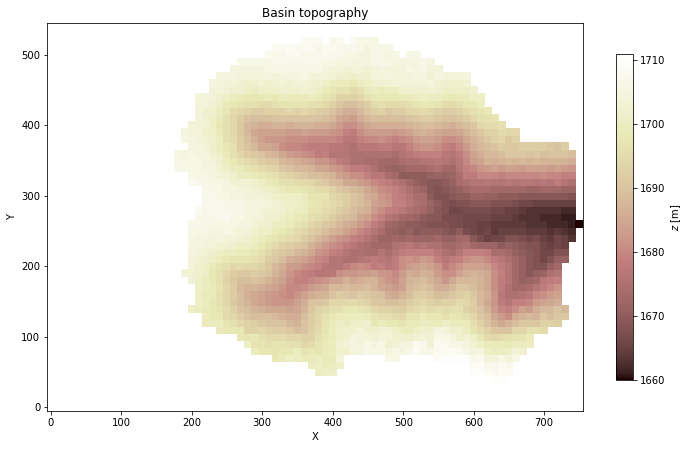

In [4]:
# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

# Plot topography
plt.figure(figsize=(12,8))
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]",\
            shrink = 0.75)

### 1.2 Find flowpaths from raster topography

We start by finding the drainage network and defining a minimum flow accumulation to define the channel using the `FLowAccumulation` and `ChannelProflier` packages.

In [5]:
# Package for finding flow accumulation in each grid cell
from landlab.components import FlowAccumulator

# Open documentation of this package
#FlowAccumulator?

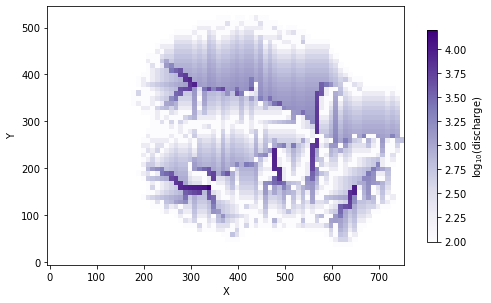

In [6]:
# Call FlowAccumulator on our grid 
fa = FlowAccumulator(rmg, 
                     'topographic__elevation',
                     flow_director='FlowDirectorSteepest')
fa.run_one_step()

# Plot flow accumulation after one timestep
plt.figure(figsize=(8,6))
imshow_grid_at_node(rmg,\
                    np.log10(rmg.at_node['surface_water__discharge']),\
                    color_for_closed=None,cmap="Purples",shrink = 0.65,\
                    colorbar_label='log$_{10}$(discharge)')

That doesn't look like a very well defined channel network, let's fill in those depressions that are affecting the flow and then reroute it:

In [7]:
# Package for finding water accumulation depressions
from landlab.components import DepressionFinderAndRouter

#Open documentation of this package
#DepressionFinderAndRouter?

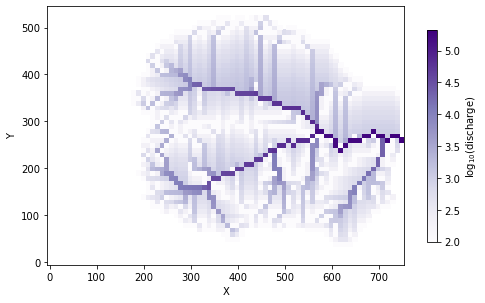

In [8]:
df_4 = DepressionFinderAndRouter(rmg)
df_4.map_depressions()

plt.figure(figsize=(8,6))
imshow_grid_at_node(rmg,
                    np.log10(rmg.at_node['surface_water__discharge']),
                    color_for_closed=None,cmap="Purples",shrink = 0.65,\
                    colorbar_label='log$_{10}$(discharge)')

Now, we use the `ChannelProfiler` package to extract the channels. The variable `'min_channel_thresh'` will define the threshold of flow accumulation required for a channel to be identified:
* Note: the complexity of the network modified by `'min_channel_thresh'` may affect the capabilities of the NetworkGrid set-up and the NetworkSedimentTransport model
    * You should ensure your `'min_channel_thresh'` is low enough to represent the catchment channels but high enough that that there aren't too many channels
    * We recommend a `'min_channel_thresh'` between 8,000 - 30,000 $m^2$

(*Notice that the discharge plots above were in log scale!*)

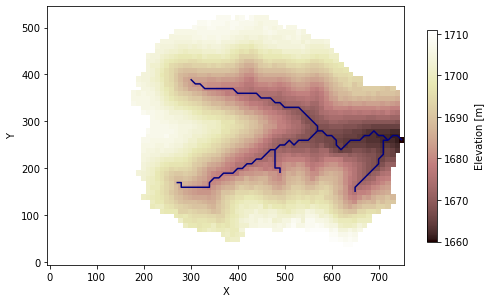

In [9]:
# Package for using water accumulation to exctract Channel profiler.
from landlab.components import ChannelProfiler
min_channel_thresh = 10000

def runChannelProfiler(Threshold):
  Threshold = 10**Threshold
  pf = ChannelProfiler(
    rmg,
    number_of_watersheds=1,
    minimum_channel_threshold=Threshold,
    main_channel_only=False,
    cmap='jet',
  )
  pf.run_one_step()
  plt.figure(figsize = (8,6))
  pf.plot_profiles_in_map_view(\
    colorbar_label='Elevation [m]',shrink=0.65,\
    color_for_closed=None)
  plt.show()
  return pf

profiler = runChannelProfiler(np.log10(min_channel_thresh))

#### Play here ⚽:
You can toggle this minimum channel threshold to refine the network!

In [10]:
# Create a slider for moving the threshold
iw.interact_manual(runChannelProfiler,\
               Threshold=iw.FloatSlider(min=0, max=5, value=4 , step=0.2));

interactive(children=(FloatSlider(value=4.0, description='Threshold', max=5.0, step=0.2), Button(description='…

What does the elevation of the channels look like going upstream?

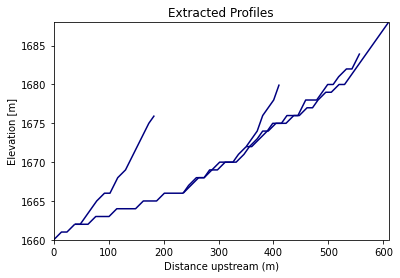

In [11]:
profiler.plot_profiles(xlabel='Distance upstream (m)',ylabel='Elevation [m]')

### 1.3 Create channel network grid
Now we can create a `network_grid`. This network is composed of nodes and links, meaning it will work as a one-dimensional grid. We iterate through the watershed segments of the Channel profiler to define nodes at regular intervals `'d_node_spacing'`

* Note: both of the following should be considered when setting node spacing
    * `d_node_spacing` cannot be longer than shortest link segment (you don't want to skip channel segments! If you do want longer grid spacings, adjust the 'min_channel_thresh' variable in the ChannelProfiler function above in order to exclude smaller channel segments.
    * `d_node_spacing` should be greater than grid resolution (it doesn't make sense to have nodes that are closer together than channels can be resolved by the underlying DEM)

In [12]:
d_node_spacing = 20 #units to space nodes (see considerations above)

#obtain watershed key to access data from ChannelProfiler data structure
ws_keys = [k for k in profiler.data_structure.keys()]

#send message if there is more than 1 watershed (code is not currently set up to handle multipe watersheds)
if len(ws_keys) > 1:
    print('More than one watershed in DEM, unable to deliniate network properly')

#access number of channel segments
n_channel_segs = len(profiler.data_structure[ws_keys[0]])
#generate random colors to keep track of channel segs for plotting
colors = [list(np.random.random(3)) for i in range(n_channel_segs)] 

Now we loop through each watershed segment to define the links and nodes of the `network_grid`.

In [13]:
x_of_nodes = np.array([]) #empty list to store x locations of network model grid nodes
y_of_nodes = np.array([]) #empty list to store y locations of network model grid nodes
rmg_nodes = np.array([]) #empty list to store raster model grid node corresponding to each network model grid node
colors_nodes = [] #empty list to store colors corresponding to each channel segment
nodes_per_segment = [] #empty list to store number of nodes in each channel segment

links = [] #empty list to store links of network model grid
node_xy = []#empty list to store xy locations of network model grid nodes

#find the nodes of the start and end index of each segment
ws_start =[ws_seg[0] for ws_seg in profiler.data_structure[ws_keys[0]].keys()] 
ws_end = [ws_seg[1] for ws_seg in profiler.data_structure[ws_keys[0]].keys()]

#loop through each segment
for i, seg_key in enumerate(profiler.data_structure[ws_keys[0]].keys()):
    #access individual segment
    seg_i = profiler.data_structure[ws_keys[0]][seg_key] 
    #print(seg_i)
    # create array of idealized node locations using previously specified distance between nodes
    node_locs = np.arange(seg_i['distances'][0], seg_i['distances'][-1], d_node_spacing)
    n_possible_nodes = len(node_locs)
    nodes_per_segment.append(n_possible_nodes)
    
    #Find the index of the nearest channel cells to idealized node locations:
    idx_nodes = [np.abs(seg_i['distances'] - loc).argmin() for loc in node_locs]
    
    #obtain list of raster model grid nodes corresponding to channel nodes
    rmg_nodes_i = seg_i['ids'][idx_nodes]
    rmg_nodes = np.append(rmg_nodes, rmg_nodes_i) #append to list that will connect rmg node values to nmg
    
    #append x,y values to list of network model grid nodes from raster model grid
    x_of_nodes = np.append(x_of_nodes, rmg.x_of_node[rmg_nodes_i])
    y_of_nodes = np.append(y_of_nodes, rmg.y_of_node[rmg_nodes_i])
    
    #find links for x,y values
    for n in range(0,n_possible_nodes-1):

        head_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n]]])
        tail_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n+1]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n+1]]])
            
        #the code below is taken from the read_shapefile landlab code
            
        # we should expect that the head node and tail node of later links will
        # already be part of the model grid. So we check, and add the nodes,
        # if they don't already exist.

        if head_node_xy not in node_xy:
            node_xy.append(head_node_xy)

        if tail_node_xy not in node_xy:
            node_xy.append(tail_node_xy)

        # get the index of the head and tail node index.
        head_node__node_id = node_xy.index(head_node_xy)
        tail_node__node_id = node_xy.index(tail_node_xy)

        # append the head and tail node ids to the link array
        links.append((head_node__node_id, tail_node__node_id))
        
        # let's make sure we have links connecting all of our channel segments!
        # check to see if the last node needs to be connected to the start of another segment
        if n == n_possible_nodes-2:
            if seg_i['ids'][-1] in ws_start:
                #Find the segment we need to connect
                seg_n = profiler.data_structure[ws_keys[0]][(ws_start[ws_start.index(seg_i['ids'][-1])],
                                                             ws_end[ws_start.index(seg_i['ids'][-1])])]
                
                #add the x,y locations of the nodes we are connecting
                head_node_xy = (rmg.x_of_node[seg_i['ids'][idx_nodes[n+1]]], rmg.y_of_node[seg_i['ids'][idx_nodes[n+1]]])
                tail_node_xy = (rmg.x_of_node[seg_n['ids'][0]], rmg.y_of_node[seg_n['ids'][0]])
                
                #if these nodes don't already exist in the array, add them! (but they should already be there)
                if head_node_xy not in node_xy:
                    node_xy.append(head_node_xy)
                if tail_node_xy not in node_xy:
                    node_xy.append(tail_node_xy)

                # get the index of the head and tail node index
                head_node__node_id = node_xy.index(head_node_xy)
                tail_node__node_id = node_xy.index(tail_node_xy)

                # append the head and tail node ids to the link array
                links.append((head_node__node_id, tail_node__node_id))
       
    #DEV ONLY: keep track of nodes per seg as explicit x and y locations
#     x_of_nodes.append(rmg.x_of_node[rmg_nodes_i])
#     y_of_nodes.append(rmg.y_of_node[rmg_nodes_i])
    
    #add colors to correspond to each segment (this is just for dev plotting and can be removed later)
    for n in range(len(rmg_nodes_i)):
        colors_nodes.append(colors[i])

print(links)     
#get unique nodes
xy_df = pd.DataFrame({'x': x_of_nodes, 'y': y_of_nodes})
uniq_x_of_nodes = xy_df.drop_duplicates()['x'].values
uniq_y_of_nodes = xy_df.drop_duplicates()['y'].values

#print(x_of_nodes)
#print(y_of_nodes)


[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (2, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (23, 24), (24, 25), (19, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (35, 36), (36, 37), (37, 38), (38, 39), (39, 40), (40, 41), (25, 42), (42, 43), (25, 44), (44, 45), (45, 46), (46, 47), (47, 48), (48, 49), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55)]


Label the watershed segments by their id number and color nodes according to their watershed segement

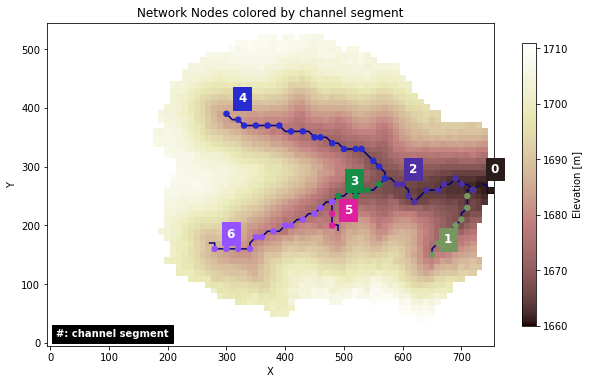

In [14]:
plt.figure(figsize = (10,8))
profiler.plot_profiles_in_map_view(\
    colorbar_label='Elevation [m]',shrink=0.65,\
    color_for_closed=None,output=False)
plt.scatter(x_of_nodes, y_of_nodes, c=colors_nodes, s=30, zorder=2)

#hacky way to label channel segments with #s -------
node_id = 0 #dummy counter
idx_x = [] #store indexes to acces x,y location of last node on channel
#loop through channels, get node index
for node_len in nodes_per_segment:
    node_id+=node_len
    idx_x.append(node_id-1)
#plot numbers at last node for each channel seg
for i in range(n_channel_segs):
    plt.text(x_of_nodes[idx_x[i]]+20,
             y_of_nodes[idx_x[i]]+20,
             '%d'%i,
             color='white',backgroundcolor=colors[i],
             fontweight='bold',fontsize="large")
plt.text(10,10,'#: channel segment',
         color='white', backgroundcolor="black",
         fontweight='bold')
plt.title('Network Nodes colored by channel segment')
plt.show()

Now we are ready to create a network model grid with the list of  nodes and linkes found.

In [15]:
# Package for building a Network Model Grid
from landlab.grid.network import NetworkModelGrid
# Package for building a building a Network Graph
from landlab.graph.graph import NetworkGraph

x_of_node, y_of_node = zip(*node_xy)

# We want to ensure that we maintain sorting, so start by creating an
# unsorted network graph and sorting.
# The sorting is important to ensure that the fields are assigned to
# the correct links.
graph_net = NetworkGraph((y_of_node, x_of_node), links=links, sort=False)
#                        ^                    ^ ^          ^
#                        ^--Node Coordinates--^ ^-Links id-^

sorted_nodes, sorted_links, sorted_patches = graph_net.sort()

# use the sorting information to make a new network model grid.
network_grid = NetworkModelGrid(
    (np.asarray(y_of_node)[sorted_nodes], np.asarray(x_of_node)[sorted_nodes]),
     np.vstack((graph_net.node_at_link_head, graph_net.node_at_link_tail)).T,
)

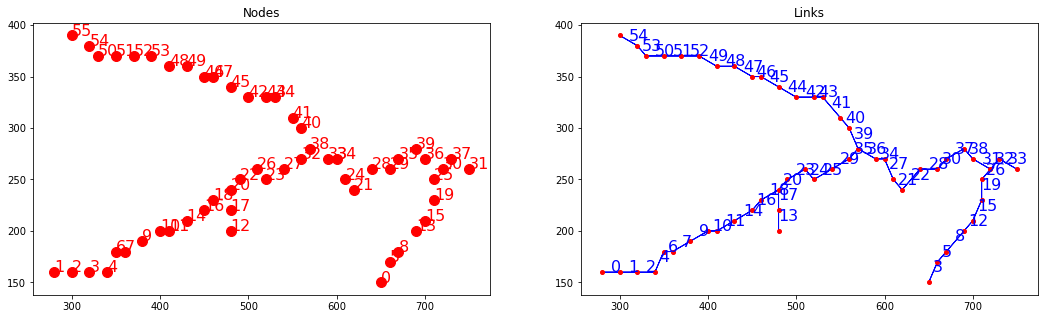

In [16]:
# Package for plotting networks
from landlab.plot import graph

## Plot nodes
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
graph.plot_nodes(network_grid)
plt.title("Nodes")

## Plot nodes + links
plt.subplot(1,2,2)
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(network_grid)
plt.title("Links")
plt.show()

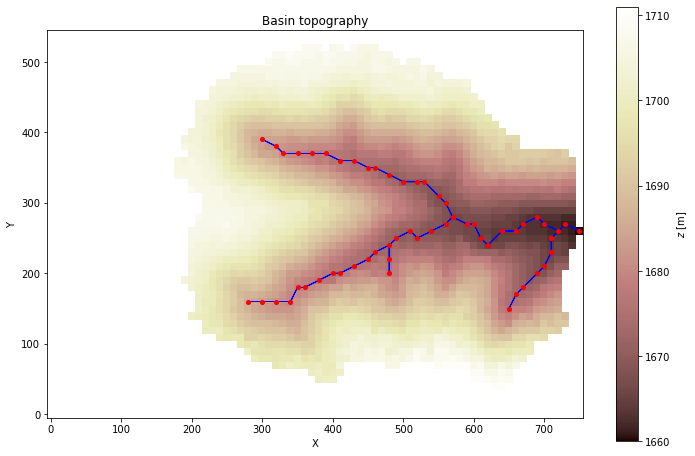

In [17]:
# Package for plotting raster data
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node

# Plot topography
plt.figure(figsize=(12,8))
graph.plot_nodes(network_grid,with_id=False,markersize=4)
graph.plot_links(network_grid,with_id=False)
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]")
plt.show()

***
## 2. Rainfall and runoff on a topography

### 2.2 Add a storm

Rain is added as a layer of water on top of the topography imported before. For the overland flow model, this is done by adding information to the `surface_water__depth` attribute of the grid `rmg` we are working on. 

First, we can add a homogeneous rain falling over the whole domain just by populating `surface_water__depth` with a constant value `h_init`.

In [18]:
# Initial thin layer of water (m)
h_init = 0.05 

# Start with a dry terrain
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)

h = rmg.at_node['surface_water__depth']  # h >> surface water depth
h += h_init   

Similarly, a spatially variable rain pattern can be added modifying the array `h`. In this case, we add some more rain in a rectagular region. 

In [19]:
# Create a list of indexes where to add the rain
bools = (rmg.node_y > 100)*(rmg.node_y < 450)*(rmg.node_x < 400)*(rmg.node_x > 200)

# Add the rain only to the indexes defined above
h[bools] = 0.15 #initial water depth m

Let's check how this rain is distributed on the basin by plotting `h` with the `imshow_grid` function. 

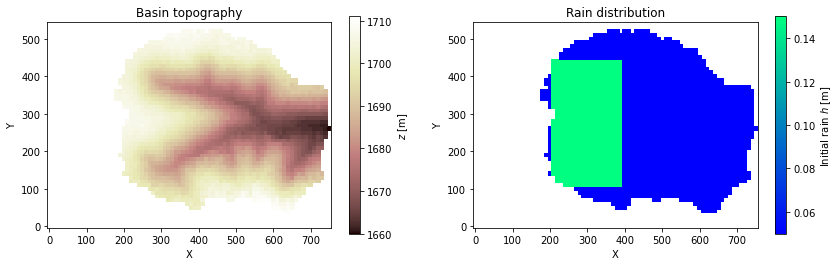

In [20]:
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
imshow_grid(rmg, 'topographic__elevation',\
            plot_name="Basin topography",\
            color_for_closed=None,\
            colorbar_label="$z$ [m]",\
            output=None,shrink=0.5)
plt.subplot(1,2,2)
imshow_grid(rmg, h,\
            plot_name="Rain distribution",\
            color_for_closed=None,\
            colorbar_label="Initial rain $h$ [m]",\
            cmap="winter",output=None,shrink=0.5)
plt.show()

### 2.3 Calculate the discharge

The rain field will act as the initial condition for the Overland Flow model to calculate the discharge in the basin. We start by initializing the `surface_water__discharge` attribute in `rmg`.

In [21]:
## Set inital discharge to zero
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

***
## 3. Sediment transport